# 3D patch-based segmentation with U-Net

Code started from [Francesco's tutorials](https://github.com/FrancescoLR/tutorials)



## Setup imports

In [13]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile
import matplotlib.pyplot as plt


import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader, CacheDataset, Dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ResizeWithPadOrCropd,
    RandCropByPosNegLabeld,
    Lambdad,
    ScaleIntensityd,
)
from monai.utils import first


import ignite
import torch

print_config()

MONAI version: 0.9.1rc3+6.g345b8ae7
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu116
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 345b8ae72870828d23383013a2b4e222f8898b26
MONAI __file__: /home/dres/FinalDeepLearning/segment/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup 


In [14]:
main_dir = '/home/dres/FinalDeepLearning/Final_segmentation' 
data_dir = '/home/dres/FinalDeepLearning/Final_segmentation/data'
[print(f"Data directory is: {data_dir}") if os.path.isdir(data_dir) else print("Check your data directory")]
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(torch.cuda.is_available())

Data directory is: /home/dres/FinalDeepLearning/Final_segmentation/data
True


### Set images and segmentation paths

- "_1" to depict training without WM heterogeneity (FaBiAN v1.0)
- "_2" to depict training with WM heterogeneity (FaBiAN v2.0)

In [15]:
train_images_1 = []
train_images_2 = []
train_labels_1 = []
train_labels_2 = []
test_images = []
test_labels = []

subject_train_folders_1 = sorted(glob.glob(os.path.join(data_dir, "training_1", "sub-*", "anat")))
subject_train_folders_2 = sorted(glob.glob(os.path.join(data_dir, "training_2", "sub-*", "anat")))
subject_test_folders = sorted(glob.glob(os.path.join(data_dir, "test", "sub-*", "anat")))
for sub_dir in subject_train_folders_1:
    train_images_1.append(glob.glob(os.path.join(sub_dir, "*T2w.nii.gz")))
    train_labels_1.append(glob.glob(os.path.join(sub_dir, "*dseg.nii.gz")))

for sub_dir in subject_train_folders_2:
    train_images_2.append(glob.glob(os.path.join(sub_dir, "*T2w.nii.gz")))
    train_labels_2.append(glob.glob(os.path.join(sub_dir, "*dseg.nii.gz")))

for sub_dir in subject_test_folders:
    test_images.append(glob.glob(os.path.join(sub_dir, "*T2w.nii.gz")))
    test_labels.append(glob.glob(os.path.join(sub_dir, "*dseg.nii.gz")))


data_train_dicts_1 = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images_1, train_labels_1)
]

data_train_dicts_2 = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images_2, train_labels_2)
]

data_test_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(test_images, test_labels)
]

#train_data_dicts, val_data_dicts = data_dicts[:-5], data_dicts[-5:]


print(f"Train dataset is composed by {len(data_train_dicts_1)} subjects and validation by {len(data_test_dicts)}.")


Train dataset is composed by 75 subjects and validation by 25.


### Set transforms and dataset

In [26]:
# Function to crop the brain from the medical image
def masked(data_dict):
    brain_mask = (data_dict["label"] != 0)
    brain_mask[brain_mask == True] = 1
    brain_mask[brain_mask == False] = 0
    data_dict["image"] = data_dict["image"] * brain_mask

    return data_dict
    
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), #Load image file or files from provided path based on reader.
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        ScaleIntensityd(keys=["image"], ), #Scale the intensity of input image to the given value range (minv, maxv). If minv and maxv and factor not provided, Normalize the data
        EnsureChannelFirstd(keys=["image", "label"]), #Automatically adjust or add the channel dimension of input data to ensure channel_first shape.
        Orientationd(keys=["image", "label"], axcodes="RAS"), #Change the input image’s orientation into the specified based on axcodes.
        Spacingd(keys=["image", "label"], pixdim=(
            0.8, 0.8, 0.8), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(160,160,160)),
        masked,
        RandCropByPosNegLabeld( #Crop random fixed sized regions with the center being a foreground or background voxel based on the Pos Neg Ratio. I recommend to use it since improves dice and IoU score
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
        


)
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        ScaleIntensityd(keys=["image"],),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            0.8, 0.8, 0.8), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(160,160,160)),
        masked,
        # RandCropByPosNegLabeld( #Crop random fixed sized regions with the center being a foreground or background voxel based on the Pos Neg Ratio. 
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
    ]
)

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [27]:
train_ds = CacheDataset(
    data=data_train_dicts_1, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

test_ds = CacheDataset(
    data=data_test_dicts, transform=test_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 25/25 [00:06<00:00,  4.02it/s]


#### Check transforms in DataLoader

N foreground 230636, N  background 0,unable to generate class balanced samples.
N foreground 442755, N  background 0,unable to generate class balanced samples.
N foreground 166119, N  background 0,unable to generate class balanced samples.
N foreground 391928, N  background 0,unable to generate class balanced samples.
N foreground 448916, N  background 0,unable to generate class balanced samples.
N foreground 437616, N  background 0,unable to generate class balanced samples.
N foreground 177883, N  background 0,unable to generate class balanced samples.
N foreground 683408, N  background 0,unable to generate class balanced samples.
N foreground 504756, N  background 0,unable to generate class balanced samples.
N foreground 572866, N  background 0,unable to generate class balanced samples.
N foreground 697174, N  background 0,unable to generate class balanced samples.
N foreground 641210, N  background 0,unable to generate class balanced samples.
N foreground 487922, N  background 0,una

image shape: (96, 96, 96), label shape: (96, 96, 96)
image pixdim: tensor([0.8000, 0.8000, 0.8000], dtype=torch.float64)


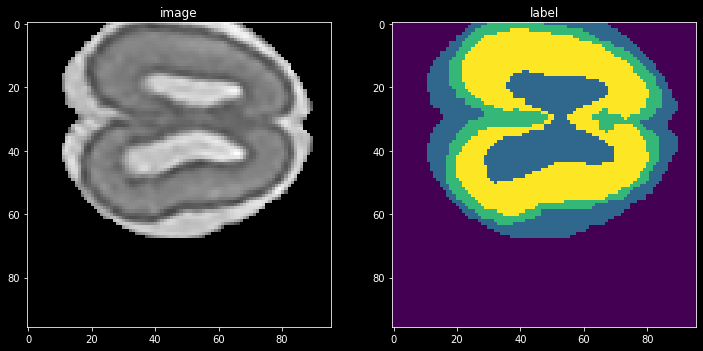

In [33]:
check_data = first(train_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f"image pixdim: {image.pixdim}")

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 50], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 50])
plt.show()
#print(len(torch.unique(label)))

## Training steps

### Create Model, Loss, Optimizer

In [35]:
# Create UNet, DiceLoss and Adam optimizer
#device = torch.device("cuda:0")
device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 7,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

### Train 

In [1]:
max_epochs = 150
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_train_loss_values = []
epoch_test_loss_values = []
metric_values = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=7)])
post_label = Compose([AsDiscrete(to_onehot=7)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_train_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            step_test = 0
            epoch_test_loss = 0
            for test_data in test_loader:
                step_test += 1
                test_inputs, test_labels = (
                    test_data["image"].to(device),
                    test_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4

                test_predictions = model(test_inputs)
                test_loss = loss_function(test_predictions, test_labels)
                epoch_test_loss += test_loss.item()

                test_outputs = sliding_window_inference(
                    test_inputs, roi_size, sw_batch_size, model)
                test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
                test_labels = [post_label(i) for i in decollate_batch(test_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=test_outputs, y=test_labels)

            epoch_test_loss /= step_test
            epoch_test_loss_values.append(epoch_test_loss)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    main_dir, "network", "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

NameError: name 'Compose' is not defined

In [26]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8346 at epoch: 149


### Plot the loss and metric

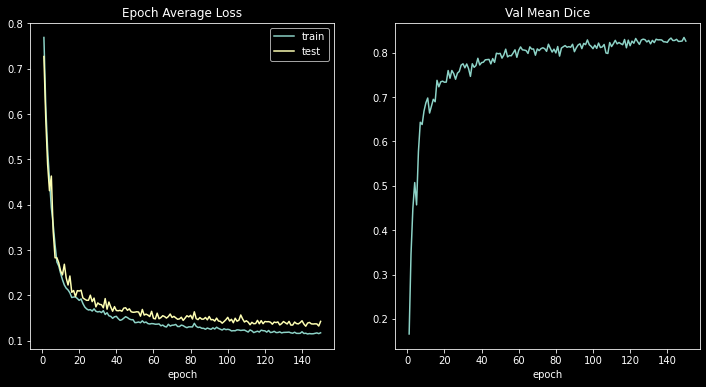

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_train_loss_values))]
plt.xlabel("epoch")
plt.plot(x, epoch_train_loss_values, label="train")
plt.plot(x, epoch_test_loss_values, label= "test")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

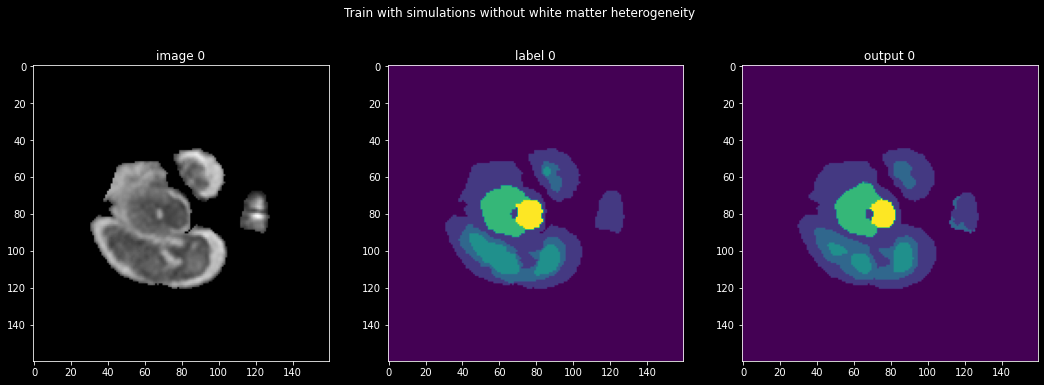

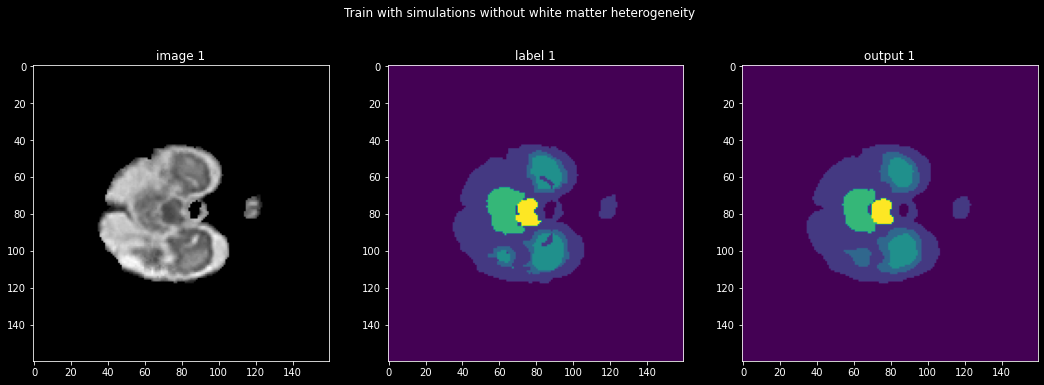

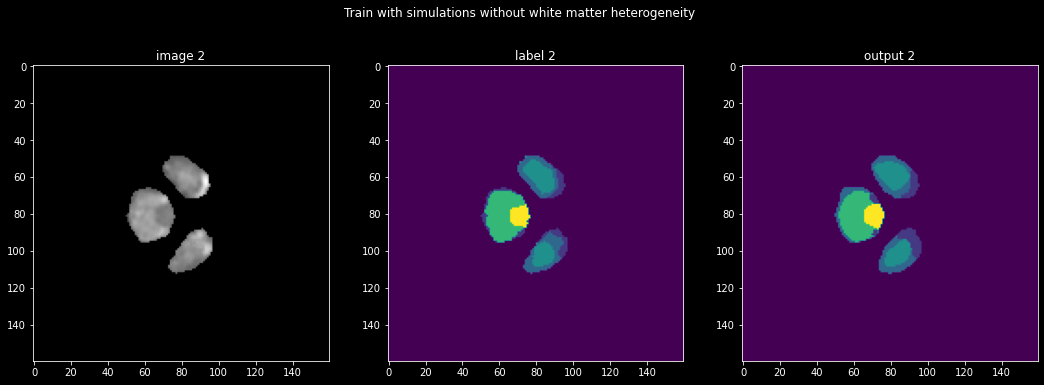

In [40]:
model.load_state_dict(torch.load(
    os.path.join(main_dir, "network", "28_07_9th", "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        fig = plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 65], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 65])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 65])
        fig.suptitle('Train with simulations without white matter heterogeneity')
        plt.show()
        if i == 2:
            break

## Another metric: Intersection Over Union (IOU) score on test set



In [27]:
model.load_state_dict(torch.load(
    os.path.join(main_dir, "network", "best_metric_model.pth")))

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=7)])
post_label = Compose([AsDiscrete(to_onehot=7)])

iou_metric = MeanIoU(include_background=False, reduction="mean")
metric_iou_values = []

model.eval()
with torch.no_grad():
    step_test = 0
    for test_data in test_loader:
        step_test += 1
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 4

        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]

        iou_metric(y_pred=test_outputs, y=test_labels)

    # aggregate the final mean dice result
    iou_array =iou_metric.get_buffer() #(25, 7) --> 25 subjects and 7 classes
    test_metric_iou = iou_metric.aggregate().item()
    print(f"Total IoU score is {test_metric_iou}.")
    # # reset the status for next validation round
    # iou_metric.reset()

    # metric_iou_values.append(test_metric_iou)

Total IoU score is 0.7525010108947754.


In [28]:
iou_array_n = iou_array[:,:-1].transpose(0, 1) # to get in each line the IoU of each class (and eliminate NaN values of backgrounf)--> (6, 25)
# iou_array_mean = torch.mean(iou_array_n[:, 0])
# iou_array_mean
iou_array_mean = []
for i, val in enumerate(iou_array_n):
    iou_array_mean.append(torch.mean(iou_array_n[:, i]).item())


iou_array_mean



[0.7726293802261353,
 0.7560156583786011,
 0.7295591235160828,
 0.77691650390625,
 0.43331819772720337,
 0.7128442525863647]